In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

c:\Users\akmal\anaconda3\envs\jcopml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# import data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/amongnikol/belajaraDataScienceJCOp/refs/heads/main/course3-regresi%26klasifikasiLanjutan/data/taxi_fare.csv', parse_dates=['pickup_datetime'])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


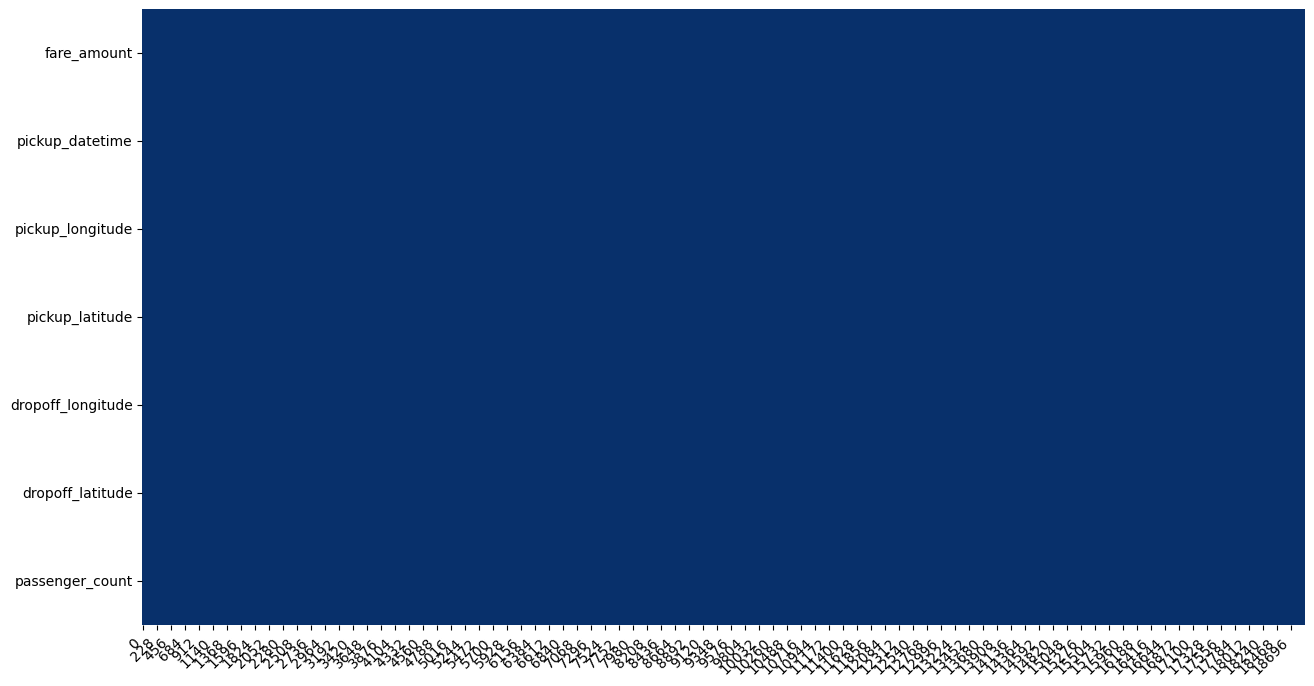

In [5]:
plot_missing_value(df)

In [6]:
df.dropna(inplace=True)

# extract time feature

In [7]:
pickup_dt = df.pickup_datetime.dt

In [8]:
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.day_of_week
df['hour'] = pickup_dt.hour
df.drop(columns='pickup_datetime', inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


# extract distance feature

In [9]:
df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude'], inplace=True)
df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# dataset splitting

In [15]:
x = df.drop(columns='fare_amount')
y = df.fare_amount

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from jcopml.tuning.space import Integer, Real

In [18]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['passenger_count', 'year', 'distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['month', 'day', 'hour'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

# cv = cross validation
model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.023086762043717957 0.01561790545280887 0.019173571744629414


# feature importance

kalau scorenya jelek jangan feature importance

# evaluasi

## actual vs prediction plot

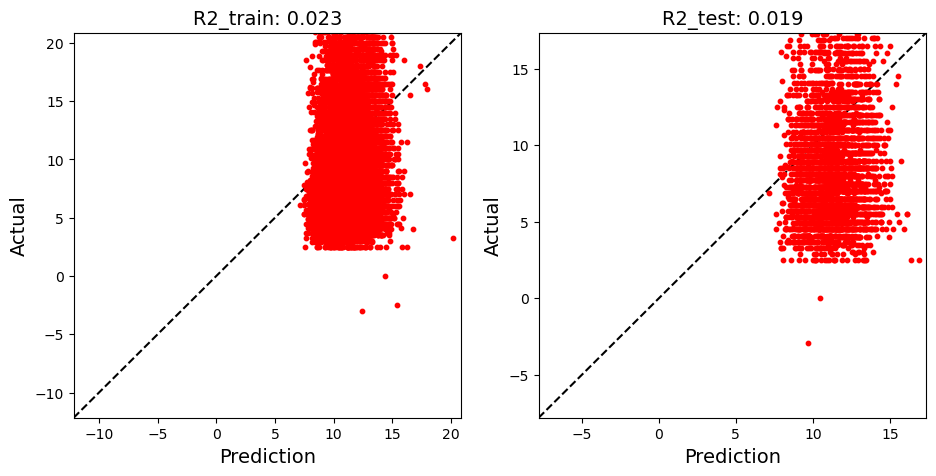

In [20]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

plot_actual_vs_prediction(x_train, y_train, x_test, y_test, model)

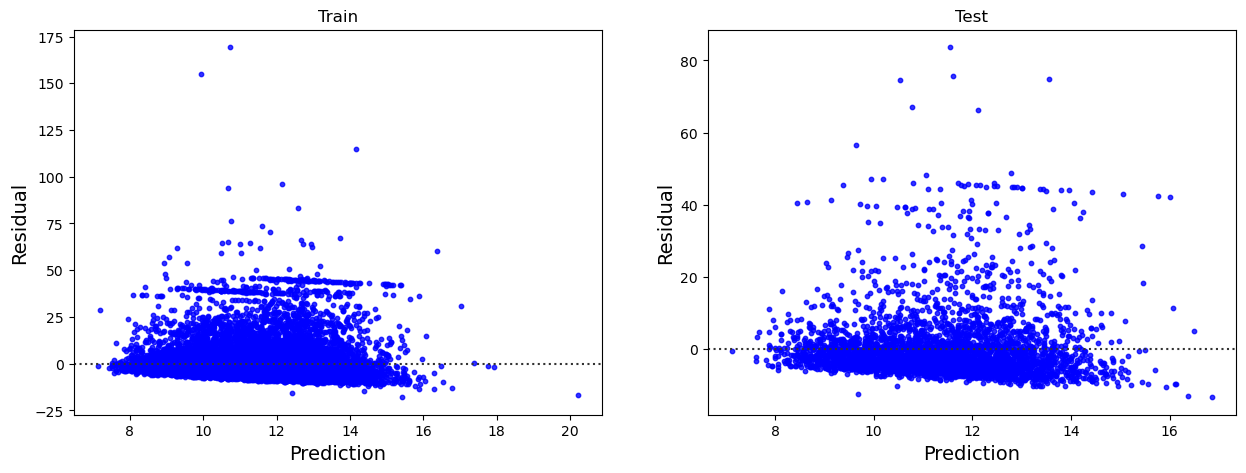

In [21]:
plot_residual(x_train, y_train, x_test, y_test, model)

# coba dengan transform

In [22]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['passenger_count', 'year', 'distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['month', 'day', 'hour'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

# cv = cross validation
model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\akmal\anaconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.6865603368824635 0.7157776836752879 0.7158744879374097


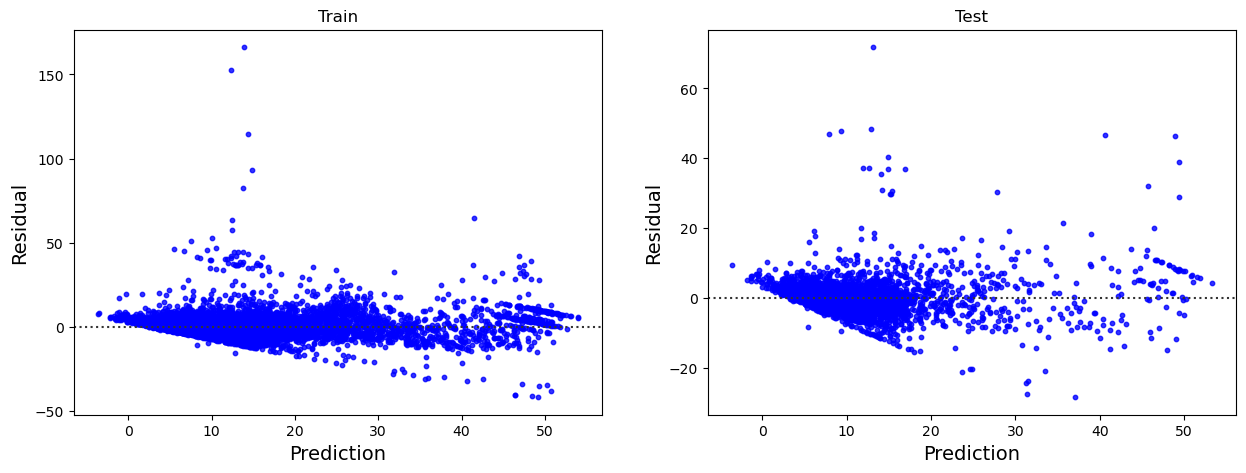

In [23]:
plot_residual(x_train, y_train, x_test, y_test, model)